In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
repo_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning'
experiments_path = os.path.join(repo_path, 'experiments/HAM10000')

In [3]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_best_epoch(df, window_size):
    val_auroc = np.array(df.val_auroc.to_list())
    windowed_auroc = [sum(val_auroc[index-window_size:index])/window_size \
                      for index in range(window_size, len(val_auroc))]
    return df.iloc[window_size+np.argmax(windowed_auroc)]

In [4]:
random_states = [1001, 2001, 3001]
random_states = [4001, 5001, 6001]
prior_scales = np.logspace(0, 9, num=10)
lr_0s = np.logspace(-1, -4, num=4)
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
window_size = 5

In [5]:
columns = ['random_state', 'prior_scale', 'test_auroc', 'test_loss', 'test_nll', 
           'test_prior', 'train_auroc', 'train_loss', 'train_nll', 'train_prior', 
           'val_auroc', 'val_loss', 'val_nll', 'val_prior']
df = pd.DataFrame(columns=columns)

for row_index, (random_state, prior_scale) in enumerate(itertools.product(random_states, prior_scales)):    
    # Get best model
    best_row = None
    for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
        df_path =  '{}/random_state={}/learned_prior_scale={}_lr_0={}_weight_decay={}.csv'\
        .format(experiments_path, random_state, prior_scale, lr_0, weight_decay)
        row = get_best_epoch(get_df(df_path), window_size=window_size)
        if best_row is None: best_row = row
        if row['val_auroc'] > best_row['val_auroc']: best_row = row
    # Append best_model to df
    row = [random_state, prior_scale, best_row.test_auroc, best_row.test_loss, 
           best_row.test_nll, best_row.test_prior, best_row.train_auroc, 
           best_row.train_loss, best_row.train_nll, best_row.train_prior, 
           best_row.val_auroc, best_row.val_loss, best_row.val_nll, 
           best_row.val_prior]
    df.loc[row_index] = row
# Average across prior_scales
df = df.groupby('prior_scale').agg(lambda x: list(x))
columns = ['test_auroc', 'test_loss', 'test_nll', 'test_prior', 
           'train_auroc', 'train_loss', 'train_nll', 'train_prior', 
           'val_auroc', 'val_loss', 'val_nll', 'val_prior']
for column in columns:
    df['{}_min'.format(column)] = df[column].apply(lambda item: np.min(item))
    df['{}_max'.format(column)] = df[column].apply(lambda item: np.max(item))
    df[column] = df[column].apply(lambda item: np.mean(item))
df.random_state = df.random_state.apply(lambda item: 'mean')
df = df.reset_index()

In [6]:
df.head()

,prior_scale,random_state,test_auroc,test_loss,test_nll,test_prior,train_auroc,train_loss,train_nll,train_prior,...,train_prior_min,train_prior_max,val_auroc_min,val_auroc_max,val_loss_min,val_loss_max,val_nll_min,val_nll_max,val_prior_min,val_prior_max
0,1.0,mean,0.858464,-55613.398438,1.035287,55614.434896,1.0,-8998.741536,0.000390,8998.741536,...,8978.993164,9023.442383,0.880045,0.898087,-18474.631866,-18288.270252,0.788075,0.946948,18289.125000,18475.419922
1,10.0,mean,0.865696,-54949.756510,0.934259,54950.691406,1.0,-8891.343681,0.000483,8891.344076,...,8871.798828,8915.805664,0.880679,0.894318,-18254.071140,-18070.127294,0.782902,0.833580,18070.960938,18254.853516
2,100.0,mean,0.862861,-50334.171875,1.008851,50335.180990,1.0,-8144.526762,0.000390,8144.527181,...,8126.614258,8166.981934,0.876934,0.896396,-16720.735169,-16552.163132,0.797573,1.047577,16553.210938,16721.542969
3,1000.0,mean,0.854763,-16927.113281,1.020992,16928.134766,1.0,-2739.071126,0.000259,2739.071370,...,2733.062744,2746.587158,0.875559,0.895761,-5622.805027,-5565.947046,0.808889,0.961157,5566.908203,5623.624023
4,10000.0,mean,0.845867,115824.333333,1.192876,-115823.140625,1.0,18740.863281,0.000228,-18740.863281,...,-18792.515625,-18699.603516,0.867085,0.896429,38090.764498,38477.653085,0.844080,1.238196,-38476.808594,-38089.527344


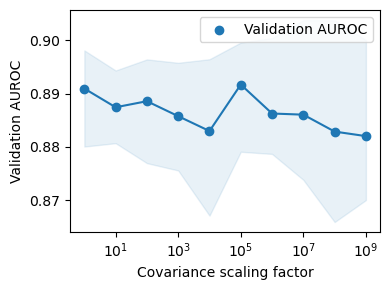

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(df.prior_scale, df.val_auroc, label='Validation AUROC', color='#1f77b4')
ax.plot(df.prior_scale, df.val_auroc, color='#1f77b4')
ax.fill_between(df.prior_scale, df.val_auroc_min, df.val_auroc_max, color='#1f77b4', alpha=0.1)
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('Validation AUROC')
ax.legend()
fig.tight_layout()
plt.show()

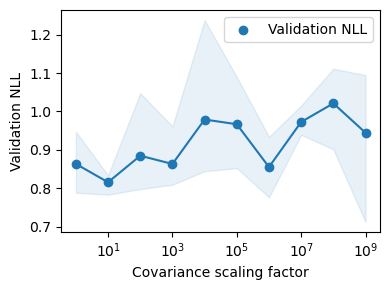

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(df.prior_scale, df.val_nll, label='Validation NLL', color='#1f77b4')
ax.plot(df.prior_scale, df.val_nll, color='#1f77b4')
ax.fill_between(df.prior_scale, df.val_nll_min, df.val_nll_max, color='#1f77b4', alpha=0.1)
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('Validation NLL')
ax.legend()
fig.tight_layout()
plt.show()

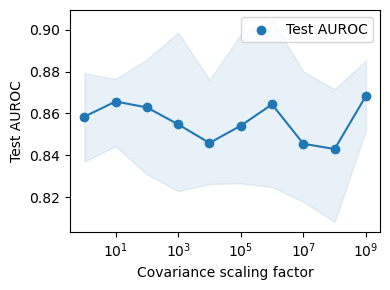

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(df.prior_scale, df.test_auroc, label='Test AUROC', color='#1f77b4')
ax.plot(df.prior_scale, df.test_auroc, color='#1f77b4')
ax.fill_between(df.prior_scale, df.test_auroc_min, df.test_auroc_max, color='#1f77b4', alpha=0.1)
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('Test AUROC')
ax.legend()
fig.tight_layout()
plt.show()

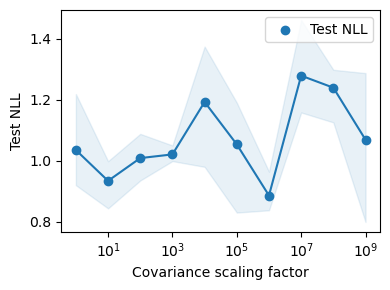

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(df.prior_scale, df.test_nll, label='Test NLL', color='#1f77b4')
ax.plot(df.prior_scale, df.test_nll, color='#1f77b4')
ax.fill_between(df.prior_scale, df.test_nll_min, df.test_nll_max, color='#1f77b4', alpha=0.1)
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('Test NLL')
ax.legend()
fig.tight_layout()
plt.show()